In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from matplotlib import patches
from matplotlib.collections import PatchCollection
import torch
import torchaudio
import torchaudio.transforms as T

/usr/lib/python3/dist-packages/torchaudio/backend/utils.py:53: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


In [2]:
def gen_mag_spectrogram(x, nfft, noverlap):
    # Computes magnitude spectrogram by specifying time.

    # window data
    step = nfft - noverlap
    shape = (nfft, (x.shape[-1]-noverlap)//step)
    strides = (x.strides[0], step*x.strides[0])
    x_wins = np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

    # apply window
    x_wins = np.hanning(x_wins.shape[0]).astype(np.float32)[..., np.newaxis] * x_wins

    # do fft
    # note this will be much slower if x_wins.shape[0] is not a power of 2
    complex_spec = np.fft.rfft(x_wins, axis=0)

    # calculate magnitude
    #spec = (np.conjugate(complex_spec) * complex_spec).real
    # same as:
    spec = np.absolute(complex_spec)**2

    # orientate the ocrrect way 
    spec = np.flipud(spec)
  
    # convert to "amplitude"
    spec = np.log(1.0 + spec)

    return spec





In [3]:
ann_path = 'annotations/BritishBatCalls_MartynCooke_2018_1_sec_train_expert.json'
audio_dir = 'audio/bat_data_martyn_2018/'
#file_of_interest = 'PipPip_D-20180620_214356-Pippip_0_1.0.wav'
file_of_interest = 'BARBAR_20180723_215600-BARBAR-LR_0_1.0.wav'


In [4]:


# load annotations
data = json.load(open(ann_path))
data_dict = {}
for dd in data:
    data_dict[dd['id']] = dd
ann = data_dict[file_of_interest]

# load audio file
# return sample rate and data
fs, x = wavfile.read(audio_dir + file_of_interest)
duration = x.shape[0] / fs

# generate spectrogram
spec = gen_mag_spectrogram(x, 1024, 768)

# print stats
print('File Name:', ann['id'])
print('Number of Events:', len(ann['annotation']))
print('sampling rate', fs)
print('duration (seconds)', duration)
print('\n')

ann

File Name: BARBAR_20180723_215600-BARBAR-LR_0_1.0.wav
Number of Events: 5
sampling rate 300000
duration (seconds) 1.0




{'annotated': True,
 'annotation': [{'class': 'Barbastellus barbastellus',
   'end_time': 0.018494791666666666,
   'event': 'Echolocation',
   'high_freq': 37841.796875,
   'individual': '0',
   'low_freq': 28808.59375,
   'start_time': 0.012734375},
  {'class': 'Barbastellus barbastellus',
   'end_time': 0.8360625,
   'event': 'Echolocation',
   'high_freq': 38085.9375,
   'individual': '0',
   'low_freq': 26855.46875,
   'start_time': 0.8307135416666667},
  {'class': 'Barbastellus barbastellus',
   'end_time': 0.51265625,
   'event': 'Echolocation',
   'high_freq': 41015.625,
   'individual': '0',
   'low_freq': 27832.03125,
   'start_time': 0.5073072916666667},
  {'class': 'Barbastellus barbastellus',
   'end_time': 0.341078125,
   'event': 'Echolocation',
   'high_freq': 39306.640625,
   'individual': '0',
   'low_freq': 28320.3125,
   'start_time': 0.33531770833333335},
  {'class': 'Barbastellus barbastellus',
   'end_time': 0.173203125,
   'event': 'Echolocation',
   'high_freq':

In [5]:
spec

array([[ 2.12177181,  3.93676072,  3.5390552 , ...,  5.04339458,
         3.22752854,  5.04454143],
       [ 1.55004529,  3.57695249,  4.42564456, ...,  5.07944672,
         3.89960801,  5.33794288],
       [ 1.95178286,  3.31368209,  3.96646943, ...,  4.48583117,
         3.31464909,  5.53608564],
       ...,
       [11.90901089,  9.53752803, 11.24285935, ...,  9.43689819,
        12.41190513, 11.33921363],
       [12.23763535, 12.56170675, 13.51807841, ..., 15.16002042,
        15.01001596, 14.33179855],
       [11.05992244, 12.36459722, 14.48344887, ..., 16.14503405,
        16.16026733, 15.34304705]])

In [6]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(spec, origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [9]:
type(spec)

numpy.ndarray

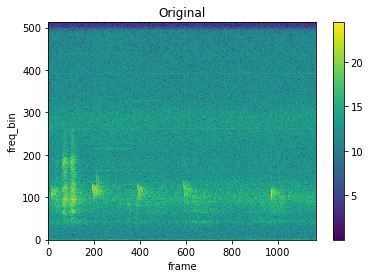

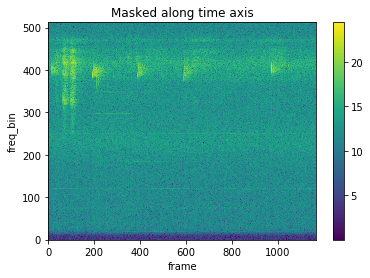

In [10]:
torch.random.manual_seed(4)

plot_spectrogram(np.flip(spec,0), title="Original")

masking = T.TimeMasking(time_mask_param=80)
# spec = masking(spec)

plot_spectrogram(spec, title="Masked along time axis")

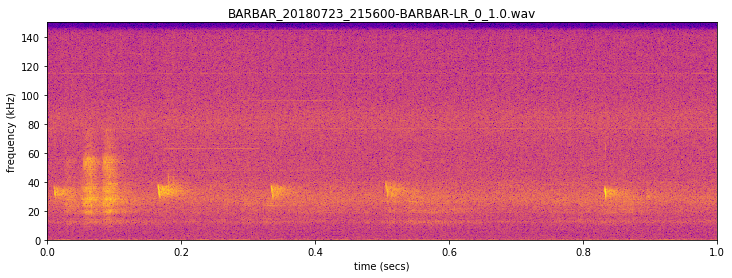

In [11]:
# parameters
freq_scale = 1000  # turn Hz in kHz
min_freq = 0
max_freq = fs / 2.0
colors = ['w', 'r', 'g', 'k', 'y', 'c', 'm']

# setup plot
plt.close('all')
plt.figure(0, figsize=(12,4))
plt.title(ann['id'])
plt.xlabel('time (secs)')
plt.ylabel('frequency (kHz)')

# plot the spectrogram
ax = plt.gca()
# extend is the size for bounding box of the image
y_extent = [0, duration, min_freq//freq_scale, max_freq//freq_scale]
ax.imshow(spec, aspect='auto', cmap='plasma', extent=y_extent)
